В цьому домашньому завданні кожне завдання оцінюється по 10 балів.

 **Завдання 1.** Після перегляду лекцій про поняття функії, вступ до лінійної алгебри і мат. формулювання лін. регресії знайдіть найкращу лінію для прогнозу `charges` за `age` **для некурців** (датафрейм `non_smoker_df`) з допомогою

1. Методу МНК (з використанням тільки `numpy`, без `scikit learn`)

2. Full-Batch градієнтного спуску з `numpy` . Протестуйте 3 різних learning rate і зробіть висновок, який є найкращим виходячи з практик для цього, наведених в лекції. Зверніть увагу, що на вхід треба набір даних дворозміний, для цього можливо треба буде трансформувати Ваші дані X в формат, як був в лекції "Математичне формулювання лінійної регресії". Також, градієнтний спуск в нашому випадку може розходитись з навчальним рейтом 0.1, бо цей рейт в цій задачі завеликий. Спробуйте нижчі рейти.
3. З `scikit-learn.LinearRegression`. Тут зверніть увагу, що вхід `X` має бути двовимірним масивом, тому нам потрібно передати dataframe, а не окрему колонку. Якщо у Вас X - колонка (а у Вас так мало б бути), то можна скористатись `X.to_frame()` щоб конвертувати колонку в датафрейм.

Для кожного методу
- знайдіть і виведіть коефіцієнти моделі
- обчисліть прогнози моделі і збережіть в окрему змінну
- порахуйте точність прогнозу RMSE  

Для градієнтного спуску виведіть графік помилки в залежності від ітерації.

А також побудуйте на одному графіку дані `age` проти `charges` в вигляді діаграми розсіювання і всі три лінії регресії, знайдені кожним з методів (для град. спуску оберіть варіант з тим learning rate, який виявився найкращим).

Зробіть висновки, чи відрізняються результати моделей?
Чи є знайдены параметри моделы близькими до ваших найкращих припущень?

In [1]:
import pandas as pd
medical_df = pd.read_csv('medical-charges.csv') 
non_smoker_df = medical_df[medical_df.smoker == 'no']

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

In [57]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [4]:
medical_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


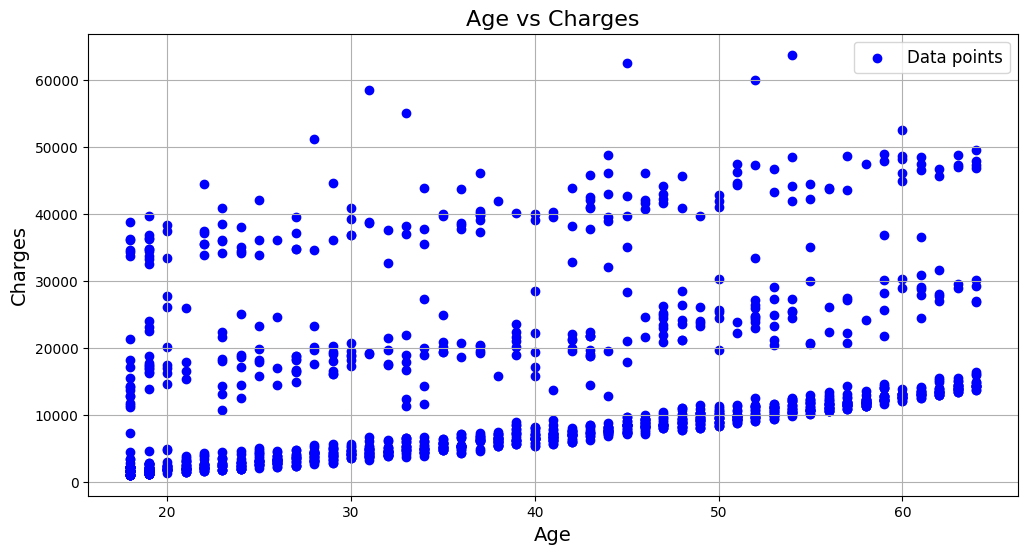

In [104]:
# візуалізував age vs charges для всіх даних без поділу на курці/не курці, щоб бути точно впевненим в картинці далі :)
plt.figure(figsize=(12, 6))
plt.scatter(medical_df['age'], medical_df['charges'], color='blue', label='Data points')
plt.title('Age vs Charges', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Charges', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

**МЕТОД МНК**

In [116]:
X_nsmokers = non_smoker_df['age'].values.reshape(-1, 1)  # перетворюємо в двовимірний масив. Перейменував дані, бо зробив спочатку завдання 2. І в результаті х та у здвіти підтягуються
y_nsmokers = non_smoker_df['charges'].values

In [106]:
def normal_equations(X_nsmokers,y_nsmokers):
    """Computes the closed-form solution to linear regression"""
    theta = np.linalg.inv(X_nsmokers.T.dot(X_nsmokers)).dot(X_nsmokers.T).dot(y_nsmokers)
    return theta

In [107]:
# Додаємо колонку одиничок аби задачи bias терм (константу в моделі регресії)
X_with_intercept = np.c_[np.ones((X_nsmokers.shape[0], 1)), X_nsmokers]
X_nsmokers[:3], X_with_intercept[:3]

(array([[18],
        [28],
        [33]], dtype=int64),
 array([[ 1., 18.],
        [ 1., 28.],
        [ 1., 33.]]))

**Коефіцієнти моделі:**

In [108]:
MNK_coefs = normal_equations(X_with_intercept, y_nsmokers)

In [109]:
MNK_coefs

array([-2091.42055657,   267.24891283])

**Прогнози моделі**

In [128]:
# Прогноз моделі для 1го спостереження
predictions_MNK = np.dot(X_with_intercept, MNK_coefs)

In [113]:
predictions_MNK[:3], y_nsmokers[:3]

(array([2719.0598744 , 5391.54900271, 6727.79356686]),
 array([ 1725.5523 ,  4449.462  , 21984.47061]))

**Точність прогнозу RMSE**

In [115]:
rmse_MNK = mean_squared_error(y_nsmokers, predictions_MNK, squared=False)
print(f"Root Mean Squared Error: {rmse_MNK:.2f}")

Root Mean Squared Error: 4662.51


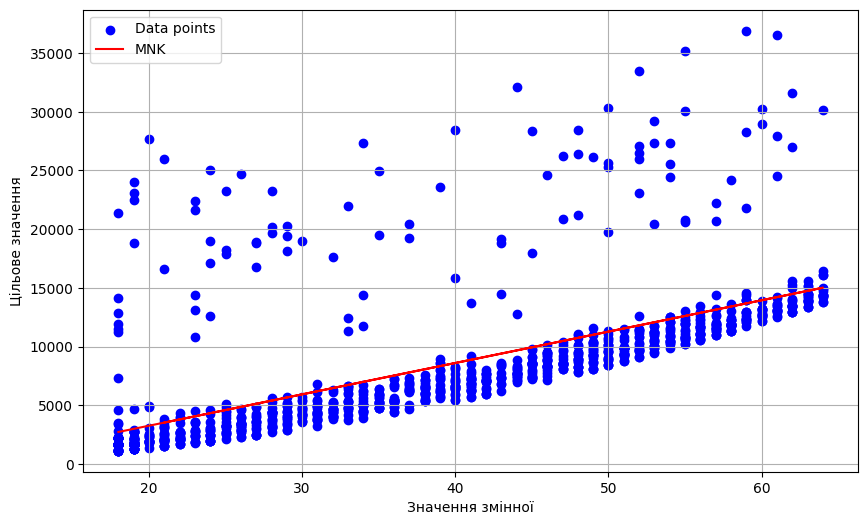

In [117]:
plt.figure(figsize=(10, 6))
plt.scatter(X_nsmokers[:, 0], y_nsmokers, color='blue', label='Data points')
plt.plot(X_nsmokers[:, 0], predictions_MNK, color='red', label='MNK')
plt.xlabel('Значення змінної')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

**FULL BATCH градієнтний спуск**

In [148]:
def full_batch_gradient_descent(X_nsmokers, y_nsmokers, lr=0.0001, epochs=100):
    m, b = 0.0, 0.0  # Початкові параметри
    n = len(y_nsmokers)
    errors = []
    for _ in range(epochs):
        y_pred = m * X_nsmokers[:, 0] + b
        error = y_pred - y_nsmokers
        errors.append(sum(error**2))
        m_gradient = (2/n) * np.dot(error, X_nsmokers[:, 0])
        b_gradient = (2/n) * np.sum(error)
        m = m - lr * m_gradient
        b = b - lr * b_gradient
    return m, b, errors

m, b, errors = full_batch_gradient_descent(X_nsmokers, y_nsmokers, lr=0.0001, epochs=1000)


m, b

(221.1045843794301, -41.98126853149978)

**Коефіцієнти**

In [157]:
m, b

(221.1045843794301, -41.98126853149978)

**Виведення передбачень**

In [149]:
predictions_fbgd = m * X_nsmokers[:, 0] + b
predictions_fbgd

array([3937.9012503 , 6148.94709409, 7254.47001599, ..., 3937.9012503 ,
       3937.9012503 , 4601.21500344])

**RMSE для градієнтного спуску**

In [153]:
rmse_fbgd = mean_squared_error(y_nsmokers, predictions_fbgd, squared=False)
print(f"Root Mean Squared Error: {rmse_fbgd:.2f}")

Root Mean Squared Error: 4713.25


**З допомогою Scikit**



In [120]:
!pip install scikit-learn --quiet

In [121]:
from sklearn.linear_model import LinearRegression

# Модель лінійної регресії засобами Scikit-learn (МНК)
lin_reg = LinearRegression()

In [122]:
lin_reg

LinearRegression()

In [123]:
lin_reg.fit(X_nsmokers, y_nsmokers)

LinearRegression()

**Коефіцієнти моделі**

In [124]:
lin_reg.coef_, lin_reg.intercept_

(array([267.24891283]), -2091.4205565650864)

**Прогнози моделі**

In [125]:
predictions_sklearn = lin_reg.predict(X_nsmokers)

In [132]:
predictions_sklearn

array([2719.0598744 , 5391.54900271, 6727.79356686, ..., 2719.0598744 ,
       2719.0598744 , 3520.80661289])

**Точність прогнозу RMSE**

In [137]:
rmse_sklearn = mean_squared_error(y_nsmokers, predictions_sklearn, squared=False)
print(f"Root Mean Squared Error: {rmse_MNK:.2f}")

Root Mean Squared Error: 4662.51


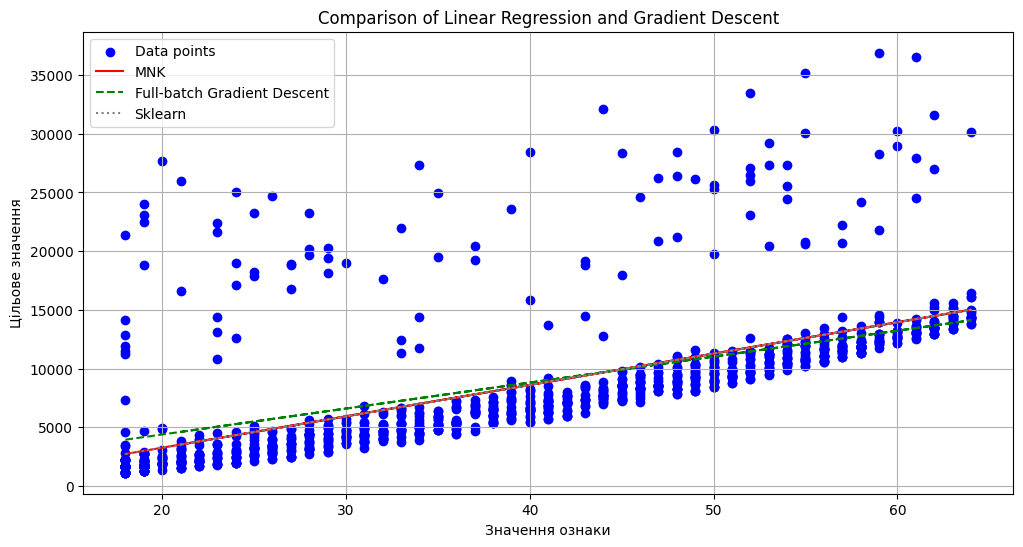

In [161]:
plt.figure(figsize=(12, 6))
plt.scatter(X_nsmokers[:, 0], y_nsmokers, color='blue', label='Data points')
plt.plot(X_nsmokers[:, 0], predictions_MNK, color='red', label='MNK',  linestyle='-')
plt.plot(X_nsmokers[:, 0], predictions_fbgd, color='green', label='Full-batch Gradient Descent',  linestyle='--')
plt.plot(X_nsmokers[:, 0], predictions_sklearn, color='grey', label='Sklearn',  linestyle=':')
plt.title('Comparison of Linear Regression and Gradient Descent')
plt.xlabel('Значення ознаки')
plt.ylabel('Цільове значення')
plt.legend()
plt.grid(True)
plt.show()

**ВИСНОВКИ ЗАВДАННЯ 1**
* Справді, МНК та sklearn ідентичні результати, оскільки sklearn юзає МНК. Бачимо навіть, що лінії обох варіантів наклалися, тому не видно червоний під сірим. Змінив стиль ліній, щоб було видно.
* Точнічність дуже схожа. RMSE досить близький. При цьому очевидно, що RMSE ідентичний для МНК та sklearn.
* Коли я вручну підбирав в попередньому ДЗ, то RMSE в двох варіантах був дуже близький.
* Однак коефіцієнти далекі від моїх найкращих припущень. Я тепер розумію чому, бо знак у intercept я пробував лише додатній. Тепер зрозуміло, що можна було гратися з різною w, але потім з допомогою знаку мінус перед intercept опустити вниз лінію регресії, щоб нахил відповідав.

 **Завдання 2.** Навчіть модель лінійної регресії з допомогою sklearn оцінювати розмір медичних збори для **курців** за їх віком.
Виведіть
- точність моделі
-  коефіцієнти
-  візуалізуйте модель у вигляді лінії на графіку розсіювання `age` проти `charges`

і зробіть висновки, чи це хороша модель, чи ви б її використовували в компанії?

In [65]:
smoker_df = medical_df[medical_df.smoker == 'yes'] # вибрав курців
smoker_df.head() # глянув на отриманий датафрейм

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
11,62,female,26.29,0,yes,southeast,27808.7251
14,27,male,42.13,0,yes,southeast,39611.7577
19,30,male,35.30,0,yes,southwest,36837.4670
23,34,female,31.92,1,yes,northeast,37701.8768


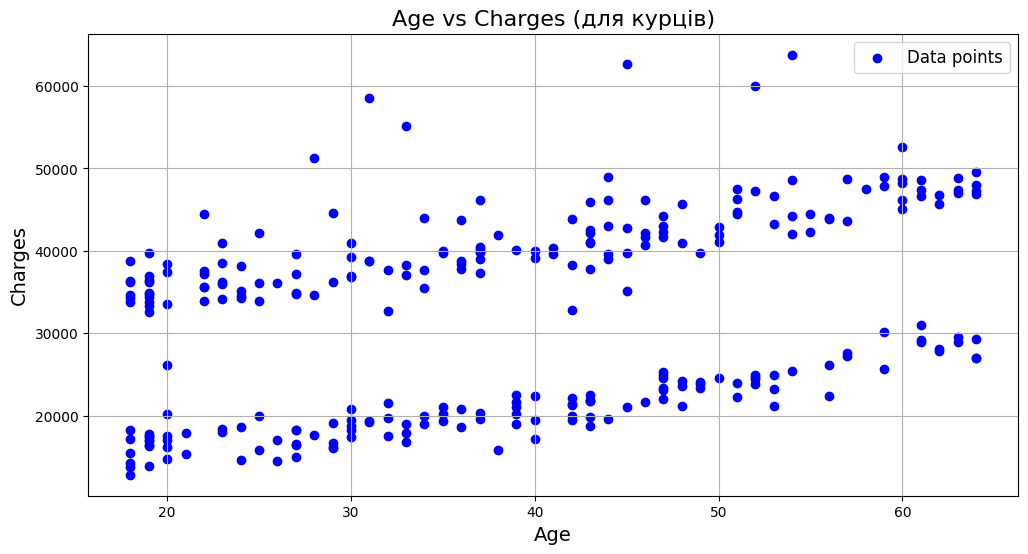

In [83]:
# візуалізував age vs charges вже наприкінці роботи в цьому місці, бо не був певний, що все правильно наприкінці
plt.figure(figsize=(12, 6))
plt.scatter(smoker_df['age'], smoker_df['charges'], color='blue', label='Data points')
plt.title('Age vs Charges (для курців)', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Charges', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [66]:
X = smoker_df['age'].to_frame() # вхідні дані мають бути двовимірним масивом, тому перетворюю в датафрейм (як в описі завдання 1)
y = smoker_df['charges']

In [45]:
reg_model = LinearRegression() 

In [46]:
reg_model

LinearRegression()

In [67]:
reg_model.fit(X,y) # навчання моделі

LinearRegression()

**Коефіцієнти моделі**

In [68]:
reg_model.coef_, reg_model.intercept_ # виведення коефіцієнтів

(array([305.23760211]), 20294.12812691597)

In [98]:
# передбачення
predictions_reg_model = reg_model.predict(X)
predictions_reg_model[:3]

array([26093.642567  , 39218.85945773, 28535.54338388])

**Оцінка якості моделі**

In [90]:
# взяв з лекції
r2 = r2_score(y, predictions_reg_model)
rmse = mean_squared_error(y, predictions_reg_model, squared=False)
mae = mean_absolute_error(y, predictions_reg_model)

print(f"R² score: {r2:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"Mean Absolute Error: {mae:.2f}")

R² score: 0.14
Root Mean Squared Error: 10711.00
Mean Absolute Error: 10097.80


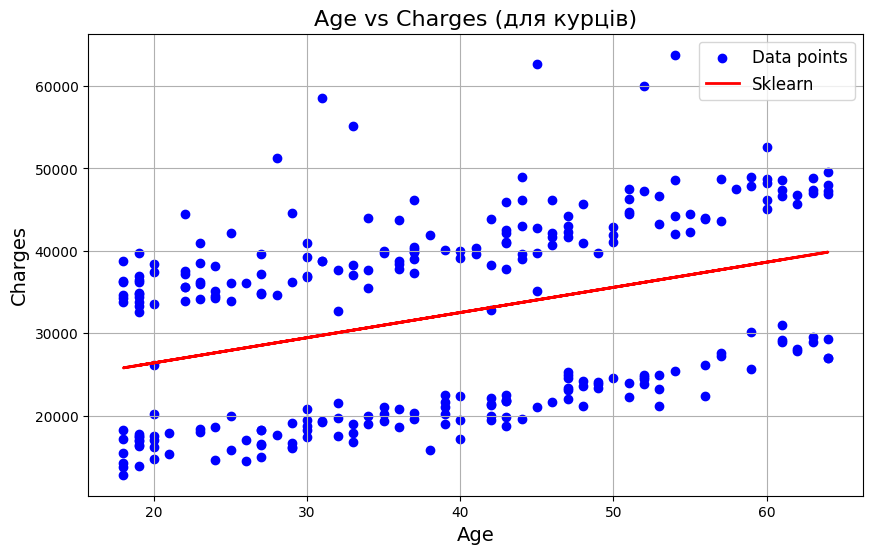

In [96]:
# візуалізація графіку
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color='blue', label='Data points')
plt.plot(X, predictions_reg_model, color='red', linewidth=2, label='Sklearn')
plt.title('Age vs Charges (для курців)', fontsize=16)
plt.xlabel('Age', fontsize=14)
plt.ylabel('Charges', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

**ВИСНОВКИ ЗАВДАННЯ 2:**
* Модель не дуже підходить. Навіть по графіку ми бачимо, що швидше за все вона не враховує всі фактори. Ми маємо 2 "групи" результатів charges для курців. Лінія нашої регресії проходить між ними. Фактично показує лише тренд. Але з її допомогою неможливо передбачити гарно.
* Таку слабкість моделі підтверджує також результат r2, який становить лише 0,14. Тобто модель може пояснити лише 14% варіатиновсті регресії.
* Також дуже великий RMSE - більше 10 тисяч, що свідчить про великий рівень помилки.
* Середня абсолютна похибка також вище 10 тисяч, що свідчить про недосконалість моделі.
* Дивлюся тепер на графіки загальних даних, даних для курців і не для курців, і тепер вже точно бачу, що результати курців це якраз наші "викиди" зі загальних даних, якщо не ділити на групи. Тому важливо досліджувати дані більш глибоко.
* Тобто знову ж таки - модель дуже погана, я б не використовував.